In [9]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import itertools
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix

DEVICE = 'cuda'


In [10]:
import torchvision.models as models #To load the ResNet model from the torchvision
model = models.resnet18(pretrained=True)
    
for param in model.parameters():
    param.requires_grad = True   
    
model.fc = nn.Sequential(
               nn.Linear(512, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 7))

c:\Users\goytom\anaconda3\envs\getuwanna\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\goytom\anaconda3\envs\getuwanna\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
# emotion_model = EmotionCNN() #For Simple CNN model defined above
cl_model = model #For the ResNet pre-trained network
cl_model.to(DEVICE) #Load the models to GPU

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
PATH = "C:/Users/goytom/Desktop/m_vis/defect_detection_ResNet18.pth"

cl_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [13]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T
import random
import matplotlib.pyplot as plt

#Path to the dataset
TRAIN_IMG_FOLDER_PATH = "C:/Users/goytom/Desktop/m_vis/data_X_SDD/train_set"
VALID_IMG_FOLDER_PATH = "C:/Users/goytom/Desktop/m_vis/data_X_SDD/test_set"
train_augs = T.Compose([
    T.Resize((224,224)),
    T.RandomHorizontalFlip(p = 0.5),
    T.RandomRotation(degrees=(-20, + 20)),
    T.ToTensor() # Convert a PIL image or numpy.ndarray to tensor (h, w, c) --> (c, h, w)
])

valid_augs = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
])


trainset = ImageFolder(TRAIN_IMG_FOLDER_PATH, transform = train_augs)
validset = ImageFolder(VALID_IMG_FOLDER_PATH, transform = valid_augs)

print(f"Total no. of examples in trainset : {len(trainset)}")
print(f"Total no. of examples in validset : {len(validset)}")

print(trainset.class_to_idx)

Total no. of examples in trainset : 949
Total no. of examples in validset : 411
{'finishing_roll_printing': 0, 'iron_sheet_ash': 1, 'oxide_scale_of_plate': 2, 'oxide_scale_of_temperature': 3, 'red_iron': 4, 'slag_inclusion': 5, 'surface_scratch': 6}


In [14]:
from torch.utils.data import DataLoader
train_loader = DataLoader(trainset, batch_size = 16, shuffle = True)
test_loader = DataLoader(validset, batch_size = 16)

print(f"Total no. of batches in trainloader : {len(train_loader)}")
print(f"Total no. of batches in validloader : {len(test_loader)}")

Total no. of batches in trainloader : 60
Total no. of batches in validloader : 26


## To check on single image

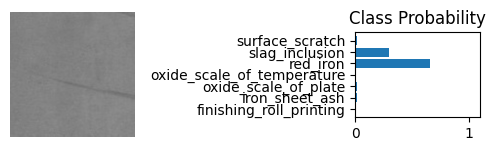

In [15]:
def view_classify(img, ps):
  
    classes = ['finishing_roll_printing', 'iron_sheet_ash','oxide_scale_of_plate', 
               'oxide_scale_of_temperature', 'red_iron', 'slag_inclusion', 'surface_scratch']
    
    ps = ps.data.cpu().numpy().squeeze()
    img = img.numpy().transpose(1,2,0)
    
    fig, (ax1, ax2) = plt.subplots(figsize = (5,9), ncols = 2)
    ax1.imshow(img)
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    
    plt.tight_layout()
    
    return None
image, label = validset[51]
image = image.unsqueeze(0)

logits = cl_model(image.to(DEVICE))
probs = nn.Softmax(dim=1)(logits)

view_classify(image.squeeze(), probs)

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")


    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)
    plt.tight_layout()

class_names = ['finishing_roll_printing', 'iron_sheet_ash','oxide_scale_of_plate', 
               'oxide_scale_of_temperature', 'red_iron', 'slag_inclusion', 'surface_scratch']
spath = "C:/Users/goytom/Desktop/m_vis/"
# Model
model.eval()
correct = 0
total = 0
all_target = []
for batch_idx, (inputs, targets) in enumerate(test_loader): #Change accordingly

    bs, c, h, w = np.shape(inputs)
    inputs = inputs.view(-1, c, h, w)
    inputs, targets = inputs.cuda(), targets.cuda()
    inputs, targets = Variable(inputs, volatile=True), Variable(targets)
    outputs = model(inputs)

    # outputs_avg = outputs.view(bs, -1).mean(1)  # avg over crops
    _, predicted = torch.max(outputs.data, 1)

    total += targets.size(0)
    correct += predicted.eq(targets.data).cpu().sum()
    if batch_idx == 0:
        all_predicted = predicted
        all_targets = targets
    else:
        all_predicted = torch.cat((all_predicted, predicted),0)
        all_targets = torch.cat((all_targets, targets),0)

acc = 100. * correct / total
print("accuracy: %0.3f" % acc)

# Compute confusion matrix
matrix = confusion_matrix(all_targets.data.cpu().numpy(),all_predicted.cpu().numpy())
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
plot_confusion_matrix(matrix, classes=class_names, normalize=False,
                      title= ' Confusion Matrix (Accuracy: %0.3f%%)' %acc)
plt.savefig(os.path.join(spath, 'Test_'+ 'none_normalized_cm.png'))
plt.close()

C:\Users\goytom\AppData\Local\Temp\ipykernel_22384\2536259533.py:49: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, targets = Variable(inputs, volatile=True), Variable(targets)


accuracy: 99.789
Confusion matrix, without normalization
[[142   0   0   0   0   0   0]
 [  1  84   0   0   0   0   0]
 [  0   0  44   0   0   0   0]
 [  1   0   0 141   0   0   0]
 [  0   0   0   0 277   0   0]
 [  0   0   0   0   0 166   0]
 [  0   0   0   0   0   0  93]]
